In [13]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "4"

# Parameters
model_name = 'meta-llama/Llama-3.1-8B'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/division_qa/qa.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/division_qa/qa.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token.pth'


In [14]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [15]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [16]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [17]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [18]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]


In [19]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 79/79 [00:10<00:00,  7.71it/s]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 79/79 [00:00<00:00, 101.47it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 39/39 [00:04<00:00,  7.86it/s]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 39/39 [00:00<00:00, 123.50it/s]


In [20]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training Epochs:   0%|          | 9/2000 [00:00<01:09, 28.48it/s]

Epoch 10/2000, Loss: 5.1209
Test Accuracy at Epoch 10: 63.16%
Test F1-score at Epoch 10: 0.7619
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.33      0.13      0.19        31
non_infringement       0.67      0.88      0.76        64

        accuracy                           0.63        95
       macro avg       0.50      0.50      0.47        95
    weighted avg       0.56      0.63      0.57        95

New best model saved with F1-score 0.7619 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       0.33      0.13      0.19        31
non_infringement       0.67      0.88      0.76        64

        accuracy                           0.63        95
       macro avg       0.50      0.50      0.47        95
    weighted avg       0.56      0.63      0.57        95



Training Epochs:   1%|          | 19/2000 [00:01<02:51, 11.56it/s]/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

Epoch 20/2000, Loss: 1.1655
Test Accuracy at Epoch 20: 67.37%
Test F1-score at Epoch 20: 0.8050
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00        31
non_infringement       0.67      1.00      0.81        64

        accuracy                           0.67        95
       macro avg       0.34      0.50      0.40        95
    weighted avg       0.45      0.67      0.54        95

New best model saved with F1-score 0.8050 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00        31
non_infringement       0.67      1.00      0.81        64

        accuracy                           0.67        95
       macro avg       0.34      0.50      0.40        95
    weighted avg       0.45      0.67      0.54        95



Training Epochs:   1%|▏         | 26/2000 [00:02<02:23, 13.76it/s]

Epoch 30/2000, Loss: 0.5777
Test Accuracy at Epoch 30: 64.21%
Test F1-score at Epoch 30: 0.7821
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00        31
non_infringement       0.66      0.95      0.78        64

        accuracy                           0.64        95
       macro avg       0.33      0.48      0.39        95
    weighted avg       0.45      0.64      0.53        95



Training Epochs:   2%|▏         | 41/2000 [00:02<01:23, 23.53it/s]

Epoch 40/2000, Loss: 0.4996
Test Accuracy at Epoch 40: 63.16%
Test F1-score at Epoch 40: 0.7742
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00        31
non_infringement       0.66      0.94      0.77        64

        accuracy                           0.63        95
       macro avg       0.33      0.47      0.39        95
    weighted avg       0.44      0.63      0.52        95



Training Epochs:   2%|▎         | 50/2000 [00:02<01:13, 26.44it/s]

Epoch 50/2000, Loss: 0.4257
Test Accuracy at Epoch 50: 64.21%
Test F1-score at Epoch 50: 0.7792
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       0.20      0.03      0.06        31
non_infringement       0.67      0.94      0.78        64

        accuracy                           0.64        95
       macro avg       0.43      0.48      0.42        95
    weighted avg       0.51      0.64      0.54        95



Training Epochs:   3%|▎         | 64/2000 [00:03<01:27, 22.00it/s]

Epoch 60/2000, Loss: 0.3834
Test Accuracy at Epoch 60: 60.00%
Test F1-score at Epoch 60: 0.7432
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:   4%|▎         | 72/2000 [00:03<01:11, 27.02it/s]

Epoch 70/2000, Loss: 0.3417
Test Accuracy at Epoch 70: 60.00%
Test F1-score at Epoch 70: 0.7432
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:   4%|▍         | 81/2000 [00:04<01:22, 23.22it/s]

Epoch 80/2000, Loss: 0.3100
Test Accuracy at Epoch 80: 60.00%
Test F1-score at Epoch 80: 0.7432
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.18      0.06      0.10        31
non_infringement       0.65      0.86      0.74        64

        accuracy                           0.60        95
       macro avg       0.42      0.46      0.42        95
    weighted avg       0.50      0.60      0.53        95



Training Epochs:   5%|▌         | 101/2000 [00:04<00:43, 43.81it/s]

Epoch 90/2000, Loss: 0.2817
Test Accuracy at Epoch 90: 60.00%
Test F1-score at Epoch 90: 0.7397
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.23      0.10      0.14        31
non_infringement       0.66      0.84      0.74        64

        accuracy                           0.60        95
       macro avg       0.44      0.47      0.44        95
    weighted avg       0.52      0.60      0.54        95

Epoch 100/2000, Loss: 0.2538
Test Accuracy at Epoch 100: 61.05%
Test F1-score at Epoch 100: 0.7413
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.31      0.16      0.21        31
non_infringement       0.67      0.83      0.74        64

        accuracy                           0.61        95
       macro avg       0.49      0.49      0.48        95
    weighted avg       0.55      0.61      0.57        95



Training Epochs:   6%|▌         | 115/2000 [00:04<00:40, 46.16it/s]

Epoch 110/2000, Loss: 0.2250
Test Accuracy at Epoch 110: 61.05%
Test F1-score at Epoch 110: 0.7376
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.33      0.19      0.24        31
non_infringement       0.68      0.81      0.74        64

        accuracy                           0.61        95
       macro avg       0.50      0.50      0.49        95
    weighted avg       0.56      0.61      0.58        95



Training Epochs:   6%|▌         | 121/2000 [00:05<00:45, 41.60it/s]

Epoch 120/2000, Loss: 0.1958
Test Accuracy at Epoch 120: 54.74%
Test F1-score at Epoch 120: 0.6767
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.27      0.23      0.25        31
non_infringement       0.65      0.70      0.68        64

        accuracy                           0.55        95
       macro avg       0.46      0.46      0.46        95
    weighted avg       0.53      0.55      0.54        95



Training Epochs:   7%|▋         | 131/2000 [00:05<00:50, 36.82it/s]

Epoch 130/2000, Loss: 0.1669
Test Accuracy at Epoch 130: 54.74%
Test F1-score at Epoch 130: 0.6767
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.27      0.23      0.25        31
non_infringement       0.65      0.70      0.68        64

        accuracy                           0.55        95
       macro avg       0.46      0.46      0.46        95
    weighted avg       0.53      0.55      0.54        95



Training Epochs:   7%|▋         | 147/2000 [00:05<00:52, 35.63it/s]

Epoch 140/2000, Loss: 0.1382
Test Accuracy at Epoch 140: 54.74%
Test F1-score at Epoch 140: 0.6718
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       0.29      0.26      0.27        31
non_infringement       0.66      0.69      0.67        64

        accuracy                           0.55        95
       macro avg       0.47      0.47      0.47        95
    weighted avg       0.54      0.55      0.54        95

Epoch 150/2000, Loss: 0.1126
Test Accuracy at Epoch 150: 54.74%
Test F1-score at Epoch 150: 0.6667
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       0.30      0.29      0.30        31
non_infringement       0.66      0.67      0.67        64

        accuracy                           0.55        95
       macro avg       0.48      0.48      0.48        95
    weighted avg       0.54      0.55      0.55        95



Training Epochs:   9%|▊         | 172/2000 [00:07<01:01, 29.86it/s]

Epoch 160/2000, Loss: 0.0909
Test Accuracy at Epoch 160: 53.68%
Test F1-score at Epoch 160: 0.6562
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       0.29      0.29      0.29        31
non_infringement       0.66      0.66      0.66        64

        accuracy                           0.54        95
       macro avg       0.47      0.47      0.47        95
    weighted avg       0.54      0.54      0.54        95

Epoch 170/2000, Loss: 0.0730
Test Accuracy at Epoch 170: 53.68%
Test F1-score at Epoch 170: 0.6562
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       0.29      0.29      0.29        31
non_infringement       0.66      0.66      0.66        64

        accuracy                           0.54        95
       macro avg       0.47      0.47      0.47        95
    weighted avg       0.54      0.54      0.54        95



Training Epochs:   9%|▉         | 183/2000 [00:07<00:48, 37.54it/s]

Epoch 180/2000, Loss: 0.0585
Test Accuracy at Epoch 180: 51.58%
Test F1-score at Epoch 180: 0.6406
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.26      0.26      0.26        31
non_infringement       0.64      0.64      0.64        64

        accuracy                           0.52        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.52      0.52        95



Training Epochs:  10%|▉         | 190/2000 [00:07<00:53, 34.07it/s]

Epoch 190/2000, Loss: 0.0470
Test Accuracy at Epoch 190: 50.53%
Test F1-score at Epoch 190: 0.6357
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.23      0.23      0.23        31
non_infringement       0.63      0.64      0.64        64

        accuracy                           0.51        95
       macro avg       0.43      0.43      0.43        95
    weighted avg       0.50      0.51      0.50        95



Training Epochs:  10%|█         | 200/2000 [00:08<00:56, 31.60it/s]

Epoch 200/2000, Loss: 0.0380
Test Accuracy at Epoch 200: 50.53%
Test F1-score at Epoch 200: 0.6357
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.23      0.23      0.23        31
non_infringement       0.63      0.64      0.64        64

        accuracy                           0.51        95
       macro avg       0.43      0.43      0.43        95
    weighted avg       0.50      0.51      0.50        95



Training Epochs:  11%|█         | 218/2000 [00:09<01:04, 27.73it/s]

Epoch 210/2000, Loss: 0.0309
Test Accuracy at Epoch 210: 50.53%
Test F1-score at Epoch 210: 0.6299
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.25      0.26      0.25        31
non_infringement       0.63      0.62      0.63        64

        accuracy                           0.51        95
       macro avg       0.44      0.44      0.44        95
    weighted avg       0.51      0.51      0.51        95

Epoch 220/2000, Loss: 0.0254
Test Accuracy at Epoch 220: 50.53%
Test F1-score at Epoch 220: 0.6299
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.25      0.26      0.25        31
non_infringement       0.63      0.62      0.63        64

        accuracy                           0.51        95
       macro avg       0.44      0.44      0.44        95
    weighted avg       0.51      0.51      0.51        95



Training Epochs:  12%|█▏        | 239/2000 [00:09<00:38, 45.19it/s]

Epoch 230/2000, Loss: 0.0212
Test Accuracy at Epoch 230: 50.53%
Test F1-score at Epoch 230: 0.6299
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.25      0.26      0.25        31
non_infringement       0.63      0.62      0.63        64

        accuracy                           0.51        95
       macro avg       0.44      0.44      0.44        95
    weighted avg       0.51      0.51      0.51        95

Epoch 240/2000, Loss: 0.0178
Test Accuracy at Epoch 240: 50.53%
Test F1-score at Epoch 240: 0.6299
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.25      0.26      0.25        31
non_infringement       0.63      0.62      0.63        64

        accuracy                           0.51        95
       macro avg       0.44      0.44      0.44        95
    weighted avg       0.51      0.51      0.51        95



Training Epochs:  12%|█▏        | 246/2000 [00:09<00:34, 50.21it/s]

Epoch 250/2000, Loss: 0.0152
Test Accuracy at Epoch 250: 50.53%
Test F1-score at Epoch 250: 0.6299
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.25      0.26      0.25        31
non_infringement       0.63      0.62      0.63        64

        accuracy                           0.51        95
       macro avg       0.44      0.44      0.44        95
    weighted avg       0.51      0.51      0.51        95



Training Epochs:  13%|█▎        | 266/2000 [00:12<02:27, 11.73it/s]

Epoch 260/2000, Loss: 0.0131
Test Accuracy at Epoch 260: 50.53%
Test F1-score at Epoch 260: 0.6299
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.25      0.26      0.25        31
non_infringement       0.63      0.62      0.63        64

        accuracy                           0.51        95
       macro avg       0.44      0.44      0.44        95
    weighted avg       0.51      0.51      0.51        95

Epoch 270/2000, Loss: 0.0114
Test Accuracy at Epoch 270: 50.53%
Test F1-score at Epoch 270: 0.6299
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.25      0.26      0.25        31
non_infringement       0.63      0.62      0.63        64

        accuracy                           0.51        95
       macro avg       0.44      0.44      0.44        95
    weighted avg       0.51      0.51      0.51        95



Training Epochs:  15%|█▍        | 292/2000 [00:12<00:57, 29.60it/s]

Epoch 280/2000, Loss: 0.0101
Test Accuracy at Epoch 280: 51.58%
Test F1-score at Epoch 280: 0.6349
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.27      0.29      0.28        31
non_infringement       0.65      0.62      0.63        64

        accuracy                           0.52        95
       macro avg       0.46      0.46      0.46        95
    weighted avg       0.52      0.52      0.52        95

Epoch 290/2000, Loss: 0.0089
Test Accuracy at Epoch 290: 50.53%
Test F1-score at Epoch 290: 0.6240
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  16%|█▌        | 310/2000 [00:12<00:38, 44.10it/s]

Epoch 300/2000, Loss: 0.0080
Test Accuracy at Epoch 300: 50.53%
Test F1-score at Epoch 300: 0.6240
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 310/2000, Loss: 0.0072
Test Accuracy at Epoch 310: 50.53%
Test F1-score at Epoch 310: 0.6240
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  16%|█▌        | 318/2000 [00:12<00:34, 49.43it/s]

Epoch 320/2000, Loss: 0.0065
Test Accuracy at Epoch 320: 50.53%
Test F1-score at Epoch 320: 0.6240
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  17%|█▋        | 341/2000 [00:13<00:33, 49.51it/s]

Epoch 330/2000, Loss: 0.0059
Test Accuracy at Epoch 330: 50.53%
Test F1-score at Epoch 330: 0.6240
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 340/2000, Loss: 0.0054
Test Accuracy at Epoch 340: 50.53%
Test F1-score at Epoch 340: 0.6240
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  18%|█▊        | 358/2000 [00:13<00:26, 60.87it/s]

Epoch 350/2000, Loss: 0.0049
Test Accuracy at Epoch 350: 50.53%
Test F1-score at Epoch 350: 0.6240
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 360/2000, Loss: 0.0045
Test Accuracy at Epoch 360: 50.53%
Test F1-score at Epoch 360: 0.6240
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  19%|█▉        | 381/2000 [00:14<00:27, 58.97it/s]

Epoch 370/2000, Loss: 0.0042
Test Accuracy at Epoch 370: 50.53%
Test F1-score at Epoch 370: 0.6240
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 380/2000, Loss: 0.0039
Test Accuracy at Epoch 380: 50.53%
Test F1-score at Epoch 380: 0.6240
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  19%|█▉        | 388/2000 [00:14<00:42, 38.13it/s]

Epoch 390/2000, Loss: 0.0036
Test Accuracy at Epoch 390: 50.53%
Test F1-score at Epoch 390: 0.6240
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  20%|██        | 409/2000 [00:15<00:41, 38.03it/s]

Epoch 400/2000, Loss: 0.0034
Test Accuracy at Epoch 400: 50.53%
Test F1-score at Epoch 400: 0.6240
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 410/2000, Loss: 0.0031
Test Accuracy at Epoch 410: 50.53%
Test F1-score at Epoch 410: 0.6240
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  22%|██▏       | 431/2000 [00:15<00:29, 53.15it/s]

Epoch 420/2000, Loss: 0.0029
Test Accuracy at Epoch 420: 50.53%
Test F1-score at Epoch 420: 0.6240
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 430/2000, Loss: 0.0028
Test Accuracy at Epoch 430: 50.53%
Test F1-score at Epoch 430: 0.6240
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  23%|██▎       | 453/2000 [00:15<00:25, 60.53it/s]

Epoch 440/2000, Loss: 0.0026
Test Accuracy at Epoch 440: 50.53%
Test F1-score at Epoch 440: 0.6240
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 450/2000, Loss: 0.0024
Test Accuracy at Epoch 450: 50.53%
Test F1-score at Epoch 450: 0.6240
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  23%|██▎       | 460/2000 [00:15<00:24, 63.00it/s]

Epoch 460/2000, Loss: 0.0023
Test Accuracy at Epoch 460: 50.53%
Test F1-score at Epoch 460: 0.6240
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  24%|██▍       | 481/2000 [00:16<00:27, 54.31it/s]

Epoch 470/2000, Loss: 0.0022
Test Accuracy at Epoch 470: 50.53%
Test F1-score at Epoch 470: 0.6240
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 480/2000, Loss: 0.0021
Test Accuracy at Epoch 480: 50.53%
Test F1-score at Epoch 480: 0.6240
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  25%|██▍       | 497/2000 [00:16<00:23, 63.62it/s]

Epoch 490/2000, Loss: 0.0020
Test Accuracy at Epoch 490: 50.53%
Test F1-score at Epoch 490: 0.6240
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 500/2000, Loss: 0.0019
Test Accuracy at Epoch 500: 50.53%
Test F1-score at Epoch 500: 0.6240
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  26%|██▌       | 518/2000 [00:16<00:22, 65.51it/s]

Epoch 510/2000, Loss: 0.0018
Test Accuracy at Epoch 510: 50.53%
Test F1-score at Epoch 510: 0.6240
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 520/2000, Loss: 0.0017
Test Accuracy at Epoch 520: 50.53%
Test F1-score at Epoch 520: 0.6240
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  27%|██▋       | 534/2000 [00:17<00:24, 59.82it/s]

Epoch 530/2000, Loss: 0.0016
Test Accuracy at Epoch 530: 50.53%
Test F1-score at Epoch 530: 0.6240
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  27%|██▋       | 548/2000 [00:17<00:23, 60.87it/s]

Epoch 540/2000, Loss: 0.0015
Test Accuracy at Epoch 540: 50.53%
Test F1-score at Epoch 540: 0.6240
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 550/2000, Loss: 0.0015
Test Accuracy at Epoch 550: 50.53%
Test F1-score at Epoch 550: 0.6240
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  28%|██▊       | 556/2000 [00:17<00:22, 63.63it/s]

Epoch 560/2000, Loss: 0.0014
Test Accuracy at Epoch 560: 50.53%
Test F1-score at Epoch 560: 0.6240
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  29%|██▉       | 580/2000 [00:18<00:27, 51.38it/s]

Epoch 570/2000, Loss: 0.0014
Test Accuracy at Epoch 570: 50.53%
Test F1-score at Epoch 570: 0.6240
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 580/2000, Loss: 0.0013
Test Accuracy at Epoch 580: 50.53%
Test F1-score at Epoch 580: 0.6240
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  30%|███       | 603/2000 [00:18<00:22, 63.28it/s]

Epoch 590/2000, Loss: 0.0012
Test Accuracy at Epoch 590: 50.53%
Test F1-score at Epoch 590: 0.6240
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 600/2000, Loss: 0.0012
Test Accuracy at Epoch 600: 50.53%
Test F1-score at Epoch 600: 0.6240
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  30%|███       | 610/2000 [00:18<00:21, 63.80it/s]

Epoch 610/2000, Loss: 0.0011
Test Accuracy at Epoch 610: 50.53%
Test F1-score at Epoch 610: 0.6240
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  32%|███▏      | 631/2000 [00:21<01:22, 16.55it/s]

Epoch 620/2000, Loss: 0.0011
Test Accuracy at Epoch 620: 50.53%
Test F1-score at Epoch 620: 0.6240
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 630/2000, Loss: 0.0011
Test Accuracy at Epoch 630: 50.53%
Test F1-score at Epoch 630: 0.6240
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  32%|███▏      | 640/2000 [00:21<00:59, 22.73it/s]

Epoch 640/2000, Loss: 0.0010
Test Accuracy at Epoch 640: 50.53%
Test F1-score at Epoch 640: 0.6240
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  33%|███▎      | 662/2000 [00:21<00:44, 30.30it/s]

Epoch 650/2000, Loss: 0.0010
Test Accuracy at Epoch 650: 50.53%
Test F1-score at Epoch 650: 0.6240
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 660/2000, Loss: 0.0010
Test Accuracy at Epoch 660: 50.53%
Test F1-score at Epoch 660: 0.6240
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  34%|███▍      | 678/2000 [00:22<00:29, 44.32it/s]

Epoch 670/2000, Loss: 0.0009
Test Accuracy at Epoch 670: 50.53%
Test F1-score at Epoch 670: 0.6240
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 680/2000, Loss: 0.0009
Test Accuracy at Epoch 680: 50.53%
Test F1-score at Epoch 680: 0.6240
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  35%|███▍      | 693/2000 [00:22<00:38, 33.91it/s]

Epoch 690/2000, Loss: 0.0009
Test Accuracy at Epoch 690: 50.53%
Test F1-score at Epoch 690: 0.6240
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  35%|███▌      | 708/2000 [00:22<00:29, 44.22it/s]

Epoch 700/2000, Loss: 0.0008
Test Accuracy at Epoch 700: 50.53%
Test F1-score at Epoch 700: 0.6240
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 710/2000, Loss: 0.0008
Test Accuracy at Epoch 710: 50.53%
Test F1-score at Epoch 710: 0.6240
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  36%|███▋      | 730/2000 [00:23<00:24, 52.56it/s]

Epoch 720/2000, Loss: 0.0008
Test Accuracy at Epoch 720: 50.53%
Test F1-score at Epoch 720: 0.6240
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 730/2000, Loss: 0.0008
Test Accuracy at Epoch 730: 50.53%
Test F1-score at Epoch 730: 0.6240
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  38%|███▊      | 750/2000 [00:23<00:20, 60.20it/s]

Epoch 740/2000, Loss: 0.0007
Test Accuracy at Epoch 740: 50.53%
Test F1-score at Epoch 740: 0.6240
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 750/2000, Loss: 0.0007
Test Accuracy at Epoch 750: 50.53%
Test F1-score at Epoch 750: 0.6240
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  39%|███▊      | 771/2000 [00:23<00:19, 64.22it/s]

Epoch 760/2000, Loss: 0.0007
Test Accuracy at Epoch 760: 50.53%
Test F1-score at Epoch 760: 0.6240
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 770/2000, Loss: 0.0007
Test Accuracy at Epoch 770: 50.53%
Test F1-score at Epoch 770: 0.6240
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  39%|███▉      | 786/2000 [00:24<00:18, 64.64it/s]

Epoch 780/2000, Loss: 0.0006
Test Accuracy at Epoch 780: 50.53%
Test F1-score at Epoch 780: 0.6240
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 790/2000, Loss: 0.0006
Test Accuracy at Epoch 790: 50.53%
Test F1-score at Epoch 790: 0.6240
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  40%|████      | 808/2000 [00:24<00:18, 66.14it/s]

Epoch 800/2000, Loss: 0.0006
Test Accuracy at Epoch 800: 50.53%
Test F1-score at Epoch 800: 0.6240
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 810/2000, Loss: 0.0006
Test Accuracy at Epoch 810: 50.53%
Test F1-score at Epoch 810: 0.6240
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  42%|████▏     | 830/2000 [00:24<00:16, 70.06it/s]

Epoch 820/2000, Loss: 0.0006
Test Accuracy at Epoch 820: 50.53%
Test F1-score at Epoch 820: 0.6240
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 830/2000, Loss: 0.0006
Test Accuracy at Epoch 830: 50.53%
Test F1-score at Epoch 830: 0.6240
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  42%|████▏     | 846/2000 [00:24<00:16, 68.09it/s]

Epoch 840/2000, Loss: 0.0005
Test Accuracy at Epoch 840: 50.53%
Test F1-score at Epoch 840: 0.6240
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 850/2000, Loss: 0.0005
Test Accuracy at Epoch 850: 50.53%
Test F1-score at Epoch 850: 0.6240
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  43%|████▎     | 867/2000 [00:25<00:19, 57.58it/s]

Epoch 860/2000, Loss: 0.0005
Test Accuracy at Epoch 860: 50.53%
Test F1-score at Epoch 860: 0.6240
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  44%|████▍     | 880/2000 [00:26<00:43, 25.91it/s]

Epoch 870/2000, Loss: 0.0005
Test Accuracy at Epoch 870: 50.53%
Test F1-score at Epoch 870: 0.6240
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 880/2000, Loss: 0.0005
Test Accuracy at Epoch 880: 50.53%
Test F1-score at Epoch 880: 0.6240
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  45%|████▌     | 900/2000 [00:26<00:26, 40.83it/s]

Epoch 890/2000, Loss: 0.0005
Test Accuracy at Epoch 890: 50.53%
Test F1-score at Epoch 890: 0.6240
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 900/2000, Loss: 0.0005
Test Accuracy at Epoch 900: 50.53%
Test F1-score at Epoch 900: 0.6240
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  46%|████▌     | 919/2000 [00:26<00:21, 50.64it/s]

Epoch 910/2000, Loss: 0.0005
Test Accuracy at Epoch 910: 50.53%
Test F1-score at Epoch 910: 0.6240
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 920/2000, Loss: 0.0004
Test Accuracy at Epoch 920: 50.53%
Test F1-score at Epoch 920: 0.6240
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  47%|████▋     | 931/2000 [00:28<00:55, 19.39it/s]

Epoch 930/2000, Loss: 0.0004
Test Accuracy at Epoch 930: 50.53%
Test F1-score at Epoch 930: 0.6240
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  48%|████▊     | 950/2000 [00:28<00:30, 34.25it/s]

Epoch 940/2000, Loss: 0.0004
Test Accuracy at Epoch 940: 50.53%
Test F1-score at Epoch 940: 0.6240
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 950/2000, Loss: 0.0004
Test Accuracy at Epoch 950: 50.53%
Test F1-score at Epoch 950: 0.6240
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  48%|████▊     | 968/2000 [00:29<00:31, 33.11it/s]

Epoch 960/2000, Loss: 0.0004
Test Accuracy at Epoch 960: 50.53%
Test F1-score at Epoch 960: 0.6240
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 970/2000, Loss: 0.0004
Test Accuracy at Epoch 970: 50.53%
Test F1-score at Epoch 970: 0.6240


Training Epochs:  49%|████▉     | 981/2000 [00:29<00:23, 43.51it/s]

Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 980/2000, Loss: 0.0004
Test Accuracy at Epoch 980: 50.53%
Test F1-score at Epoch 980: 0.6240
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  50%|████▉     | 994/2000 [00:29<00:21, 45.89it/s]

Epoch 990/2000, Loss: 0.0004
Test Accuracy at Epoch 990: 50.53%
Test F1-score at Epoch 990: 0.6240
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  50%|█████     | 1007/2000 [00:29<00:18, 53.25it/s]

Epoch 1000/2000, Loss: 0.0004
Test Accuracy at Epoch 1000: 50.53%
Test F1-score at Epoch 1000: 0.6240
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1010/2000, Loss: 0.0004
Test Accuracy at Epoch 1010: 50.53%
Test F1-score at Epoch 1010: 0.6240
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  51%|█████▏    | 1026/2000 [00:30<00:19, 49.02it/s]

Epoch 1020/2000, Loss: 0.0004
Test Accuracy at Epoch 1020: 50.53%
Test F1-score at Epoch 1020: 0.6240
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  52%|█████▏    | 1039/2000 [00:30<00:18, 52.25it/s]

Epoch 1030/2000, Loss: 0.0003
Test Accuracy at Epoch 1030: 50.53%
Test F1-score at Epoch 1030: 0.6240
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1040/2000, Loss: 0.0003
Test Accuracy at Epoch 1040: 50.53%
Test F1-score at Epoch 1040: 0.6240
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  53%|█████▎    | 1058/2000 [00:30<00:16, 56.44it/s]

Epoch 1050/2000, Loss: 0.0003
Test Accuracy at Epoch 1050: 50.53%
Test F1-score at Epoch 1050: 0.6240
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1060/2000, Loss: 0.0003
Test Accuracy at Epoch 1060: 50.53%
Test F1-score at Epoch 1060: 0.6240
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  53%|█████▎    | 1064/2000 [00:30<00:17, 54.55it/s]

Epoch 1070/2000, Loss: 0.0003
Test Accuracy at Epoch 1070: 50.53%
Test F1-score at Epoch 1070: 0.6240
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  55%|█████▍    | 1093/2000 [00:31<00:18, 48.66it/s]

Epoch 1080/2000, Loss: 0.0003
Test Accuracy at Epoch 1080: 50.53%
Test F1-score at Epoch 1080: 0.6240
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1090/2000, Loss: 0.0003
Test Accuracy at Epoch 1090: 50.53%
Test F1-score at Epoch 1090: 0.6240
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  55%|█████▌    | 1109/2000 [00:32<00:14, 59.83it/s]

Epoch 1100/2000, Loss: 0.0003
Test Accuracy at Epoch 1100: 50.53%
Test F1-score at Epoch 1100: 0.6240
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1110/2000, Loss: 0.0003
Test Accuracy at Epoch 1110: 50.53%
Test F1-score at Epoch 1110: 0.6240
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  56%|█████▋    | 1129/2000 [00:32<00:16, 52.06it/s]

Epoch 1120/2000, Loss: 0.0003
Test Accuracy at Epoch 1120: 50.53%
Test F1-score at Epoch 1120: 0.6240
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  57%|█████▋    | 1135/2000 [00:32<00:16, 53.28it/s]

Epoch 1130/2000, Loss: 0.0003
Test Accuracy at Epoch 1130: 50.53%
Test F1-score at Epoch 1130: 0.6240
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  57%|█████▋    | 1141/2000 [00:32<00:19, 43.24it/s]

Epoch 1140/2000, Loss: 0.0003
Test Accuracy at Epoch 1140: 50.53%
Test F1-score at Epoch 1140: 0.6240
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  57%|█████▊    | 1150/2000 [00:36<02:26,  5.80it/s]

Epoch 1150/2000, Loss: 0.0003
Test Accuracy at Epoch 1150: 50.53%
Test F1-score at Epoch 1150: 0.6240
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  58%|█████▊    | 1168/2000 [00:36<00:58, 14.22it/s]

Epoch 1160/2000, Loss: 0.0003
Test Accuracy at Epoch 1160: 50.53%
Test F1-score at Epoch 1160: 0.6240
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1170/2000, Loss: 0.0003
Test Accuracy at Epoch 1170: 50.53%
Test F1-score at Epoch 1170: 0.6240
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  59%|█████▉    | 1189/2000 [00:37<00:26, 30.06it/s]

Epoch 1180/2000, Loss: 0.0003
Test Accuracy at Epoch 1180: 50.53%
Test F1-score at Epoch 1180: 0.6240
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1190/2000, Loss: 0.0002
Test Accuracy at Epoch 1190: 50.53%
Test F1-score at Epoch 1190: 0.6240
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  60%|██████    | 1210/2000 [00:37<00:16, 47.66it/s]

Epoch 1200/2000, Loss: 0.0002
Test Accuracy at Epoch 1200: 50.53%
Test F1-score at Epoch 1200: 0.6240
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1210/2000, Loss: 0.0002
Test Accuracy at Epoch 1210: 50.53%
Test F1-score at Epoch 1210: 0.6240
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  62%|██████▏   | 1232/2000 [00:37<00:12, 61.00it/s]

Epoch 1220/2000, Loss: 0.0002
Test Accuracy at Epoch 1220: 50.53%
Test F1-score at Epoch 1220: 0.6240
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1230/2000, Loss: 0.0002
Test Accuracy at Epoch 1230: 50.53%
Test F1-score at Epoch 1230: 0.6240
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  62%|██████▏   | 1247/2000 [00:37<00:11, 63.51it/s]

Epoch 1240/2000, Loss: 0.0002
Test Accuracy at Epoch 1240: 50.53%
Test F1-score at Epoch 1240: 0.6240
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1250/2000, Loss: 0.0002
Test Accuracy at Epoch 1250: 50.53%
Test F1-score at Epoch 1250: 0.6240
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  63%|██████▎   | 1262/2000 [00:38<00:11, 66.04it/s]

Epoch 1260/2000, Loss: 0.0002
Test Accuracy at Epoch 1260: 50.53%
Test F1-score at Epoch 1260: 0.6240
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  64%|██████▍   | 1283/2000 [00:40<00:33, 21.65it/s]

Epoch 1270/2000, Loss: 0.0002
Test Accuracy at Epoch 1270: 50.53%
Test F1-score at Epoch 1270: 0.6240
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1280/2000, Loss: 0.0002
Test Accuracy at Epoch 1280: 50.53%
Test F1-score at Epoch 1280: 0.6240
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  65%|██████▍   | 1299/2000 [00:40<00:20, 35.02it/s]

Epoch 1290/2000, Loss: 0.0002
Test Accuracy at Epoch 1290: 50.53%
Test F1-score at Epoch 1290: 0.6240
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1300/2000, Loss: 0.0002
Test Accuracy at Epoch 1300: 50.53%
Test F1-score at Epoch 1300: 0.6240
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  66%|██████▋   | 1325/2000 [00:40<00:13, 49.56it/s]

Epoch 1310/2000, Loss: 0.0002
Test Accuracy at Epoch 1310: 50.53%
Test F1-score at Epoch 1310: 0.6240
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1320/2000, Loss: 0.0002
Test Accuracy at Epoch 1320: 50.53%
Test F1-score at Epoch 1320: 0.6240
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  67%|██████▋   | 1339/2000 [00:40<00:12, 54.17it/s]

Epoch 1330/2000, Loss: 0.0002
Test Accuracy at Epoch 1330: 50.53%
Test F1-score at Epoch 1330: 0.6240
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1340/2000, Loss: 0.0002
Test Accuracy at Epoch 1340: 50.53%
Test F1-score at Epoch 1340: 0.6240
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  68%|██████▊   | 1363/2000 [00:41<00:11, 54.82it/s]

Epoch 1350/2000, Loss: 0.0002
Test Accuracy at Epoch 1350: 50.53%
Test F1-score at Epoch 1350: 0.6240
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1360/2000, Loss: 0.0002
Test Accuracy at Epoch 1360: 50.53%
Test F1-score at Epoch 1360: 0.6240
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  69%|██████▉   | 1379/2000 [00:41<00:09, 63.85it/s]

Epoch 1370/2000, Loss: 0.0002
Test Accuracy at Epoch 1370: 50.53%
Test F1-score at Epoch 1370: 0.6240
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1380/2000, Loss: 0.0002
Test Accuracy at Epoch 1380: 50.53%
Test F1-score at Epoch 1380: 0.6240
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  70%|██████▉   | 1394/2000 [00:41<00:12, 49.78it/s]

Epoch 1390/2000, Loss: 0.0002
Test Accuracy at Epoch 1390: 50.53%
Test F1-score at Epoch 1390: 0.6240
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  70%|███████   | 1408/2000 [00:42<00:10, 56.17it/s]

Epoch 1400/2000, Loss: 0.0002
Test Accuracy at Epoch 1400: 50.53%
Test F1-score at Epoch 1400: 0.6240
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1410/2000, Loss: 0.0002
Test Accuracy at Epoch 1410: 50.53%
Test F1-score at Epoch 1410: 0.6240


Training Epochs:  71%|███████   | 1421/2000 [00:42<00:10, 53.81it/s]

Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1420/2000, Loss: 0.0002
Test Accuracy at Epoch 1420: 50.53%
Test F1-score at Epoch 1420: 0.6240
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  72%|███████▏  | 1430/2000 [00:42<00:09, 59.58it/s]

Epoch 1430/2000, Loss: 0.0002
Test Accuracy at Epoch 1430: 50.53%
Test F1-score at Epoch 1430: 0.6240
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  72%|███████▏  | 1437/2000 [00:44<00:47, 11.79it/s]

Epoch 1440/2000, Loss: 0.0002
Test Accuracy at Epoch 1440: 50.53%
Test F1-score at Epoch 1440: 0.6240
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  72%|███████▏  | 1449/2000 [00:48<02:06,  4.36it/s]

Epoch 1450/2000, Loss: 0.0002
Test Accuracy at Epoch 1450: 50.53%
Test F1-score at Epoch 1450: 0.6240
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  73%|███████▎  | 1460/2000 [00:53<03:11,  2.83it/s]

Epoch 1460/2000, Loss: 0.0002
Test Accuracy at Epoch 1460: 50.53%
Test F1-score at Epoch 1460: 0.6240
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  74%|███████▎  | 1471/2000 [00:56<01:53,  4.64it/s]

Epoch 1470/2000, Loss: 0.0002
Test Accuracy at Epoch 1470: 50.53%
Test F1-score at Epoch 1470: 0.6240
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  74%|███████▍  | 1478/2000 [00:56<00:41, 12.45it/s]

Epoch 1480/2000, Loss: 0.0001
Test Accuracy at Epoch 1480: 50.53%
Test F1-score at Epoch 1480: 0.6240
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  75%|███████▌  | 1502/2000 [00:58<00:20, 24.05it/s]

Epoch 1490/2000, Loss: 0.0001
Test Accuracy at Epoch 1490: 50.53%
Test F1-score at Epoch 1490: 0.6240
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1500/2000, Loss: 0.0001
Test Accuracy at Epoch 1500: 50.53%
Test F1-score at Epoch 1500: 0.6240
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  75%|███████▌  | 1507/2000 [00:59<00:47, 10.36it/s]

Epoch 1510/2000, Loss: 0.0001
Test Accuracy at Epoch 1510: 50.53%
Test F1-score at Epoch 1510: 0.6240
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  76%|███████▌  | 1520/2000 [01:04<02:18,  3.47it/s]

Epoch 1520/2000, Loss: 0.0001
Test Accuracy at Epoch 1520: 50.53%
Test F1-score at Epoch 1520: 0.6240
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  77%|███████▋  | 1539/2000 [01:06<00:25, 17.83it/s]

Epoch 1530/2000, Loss: 0.0001
Test Accuracy at Epoch 1530: 50.53%
Test F1-score at Epoch 1530: 0.6240
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1540/2000, Loss: 0.0001
Test Accuracy at Epoch 1540: 50.53%
Test F1-score at Epoch 1540: 0.6240
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  78%|███████▊  | 1560/2000 [01:07<00:10, 41.90it/s]

Epoch 1550/2000, Loss: 0.0001
Test Accuracy at Epoch 1550: 50.53%
Test F1-score at Epoch 1550: 0.6240
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1560/2000, Loss: 0.0001
Test Accuracy at Epoch 1560: 50.53%
Test F1-score at Epoch 1560: 0.6240
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  79%|███████▉  | 1576/2000 [01:07<00:08, 50.41it/s]

Epoch 1570/2000, Loss: 0.0001
Test Accuracy at Epoch 1570: 50.53%
Test F1-score at Epoch 1570: 0.6240
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1580/2000, Loss: 0.0001
Test Accuracy at Epoch 1580: 50.53%
Test F1-score at Epoch 1580: 0.6240
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  80%|████████  | 1600/2000 [01:07<00:06, 62.72it/s]

Epoch 1590/2000, Loss: 0.0001
Test Accuracy at Epoch 1590: 50.53%
Test F1-score at Epoch 1590: 0.6240
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1600/2000, Loss: 0.0001
Test Accuracy at Epoch 1600: 50.53%
Test F1-score at Epoch 1600: 0.6240
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  81%|████████  | 1619/2000 [01:07<00:05, 72.41it/s]

Epoch 1610/2000, Loss: 0.0001
Test Accuracy at Epoch 1610: 50.53%
Test F1-score at Epoch 1610: 0.6240
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1620/2000, Loss: 0.0001
Test Accuracy at Epoch 1620: 50.53%
Test F1-score at Epoch 1620: 0.6240
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  82%|████████▏ | 1635/2000 [01:08<00:05, 63.25it/s]

Epoch 1630/2000, Loss: 0.0001
Test Accuracy at Epoch 1630: 50.53%
Test F1-score at Epoch 1630: 0.6240
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1640/2000, Loss: 0.0001
Test Accuracy at Epoch 1640: 50.53%
Test F1-score at Epoch 1640: 0.6240
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  83%|████████▎ | 1657/2000 [01:08<00:06, 54.34it/s]

Epoch 1650/2000, Loss: 0.0001
Test Accuracy at Epoch 1650: 50.53%
Test F1-score at Epoch 1650: 0.6240
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  84%|████████▎ | 1671/2000 [01:08<00:05, 59.01it/s]

Epoch 1660/2000, Loss: 0.0001
Test Accuracy at Epoch 1660: 50.53%
Test F1-score at Epoch 1660: 0.6240
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1670/2000, Loss: 0.0001
Test Accuracy at Epoch 1670: 50.53%
Test F1-score at Epoch 1670: 0.6240
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  85%|████████▍ | 1695/2000 [01:09<00:04, 69.54it/s]

Epoch 1680/2000, Loss: 0.0001
Test Accuracy at Epoch 1680: 50.53%
Test F1-score at Epoch 1680: 0.6240
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1690/2000, Loss: 0.0001
Test Accuracy at Epoch 1690: 50.53%
Test F1-score at Epoch 1690: 0.6240
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  85%|████████▌ | 1703/2000 [01:09<00:04, 62.04it/s]

Epoch 1700/2000, Loss: 0.0001
Test Accuracy at Epoch 1700: 50.53%
Test F1-score at Epoch 1700: 0.6240
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1710/2000, Loss: 0.0001


Training Epochs:  86%|████████▌ | 1718/2000 [01:09<00:04, 60.59it/s]

Test Accuracy at Epoch 1710: 50.53%
Test F1-score at Epoch 1710: 0.6240
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1720/2000, Loss: 0.0001
Test Accuracy at Epoch 1720: 50.53%
Test F1-score at Epoch 1720: 0.6240
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  87%|████████▋ | 1741/2000 [01:09<00:04, 63.82it/s]

Epoch 1730/2000, Loss: 0.0001
Test Accuracy at Epoch 1730: 50.53%
Test F1-score at Epoch 1730: 0.6240
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1740/2000, Loss: 0.0001
Test Accuracy at Epoch 1740: 50.53%
Test F1-score at Epoch 1740: 0.6240
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  88%|████████▊ | 1758/2000 [01:10<00:03, 69.71it/s]

Epoch 1750/2000, Loss: 0.0001
Test Accuracy at Epoch 1750: 50.53%
Test F1-score at Epoch 1750: 0.6240
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1760/2000, Loss: 0.0001
Test Accuracy at Epoch 1760: 50.53%
Test F1-score at Epoch 1760: 0.6240
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  89%|████████▉ | 1783/2000 [01:10<00:02, 73.51it/s]

Epoch 1770/2000, Loss: 0.0001
Test Accuracy at Epoch 1770: 50.53%
Test F1-score at Epoch 1770: 0.6240
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1780/2000, Loss: 0.0001
Test Accuracy at Epoch 1780: 50.53%
Test F1-score at Epoch 1780: 0.6240
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  90%|█████████ | 1800/2000 [01:10<00:02, 76.30it/s]

Epoch 1790/2000, Loss: 0.0001
Test Accuracy at Epoch 1790: 50.53%
Test F1-score at Epoch 1790: 0.6240
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1800/2000, Loss: 0.0001
Test Accuracy at Epoch 1800: 50.53%
Test F1-score at Epoch 1800: 0.6240
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  91%|█████████ | 1824/2000 [01:11<00:02, 74.29it/s]

Epoch 1810/2000, Loss: 0.0001
Test Accuracy at Epoch 1810: 50.53%
Test F1-score at Epoch 1810: 0.6240
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1820/2000, Loss: 0.0001
Test Accuracy at Epoch 1820: 50.53%
Test F1-score at Epoch 1820: 0.6240
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  92%|█████████▏| 1840/2000 [01:11<00:02, 74.27it/s]

Epoch 1830/2000, Loss: 0.0001
Test Accuracy at Epoch 1830: 50.53%
Test F1-score at Epoch 1830: 0.6240
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1840/2000, Loss: 0.0001
Test Accuracy at Epoch 1840: 50.53%
Test F1-score at Epoch 1840: 0.6240
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  93%|█████████▎| 1857/2000 [01:11<00:01, 72.21it/s]

Epoch 1850/2000, Loss: 0.0001
Test Accuracy at Epoch 1850: 50.53%
Test F1-score at Epoch 1850: 0.6240
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1860/2000, Loss: 0.0001
Test Accuracy at Epoch 1860: 50.53%
Test F1-score at Epoch 1860: 0.6240
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  94%|█████████▍| 1881/2000 [01:11<00:01, 66.61it/s]

Epoch 1870/2000, Loss: 0.0001
Test Accuracy at Epoch 1870: 50.53%
Test F1-score at Epoch 1870: 0.6240
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95

Epoch 1880/2000, Loss: 0.0001
Test Accuracy at Epoch 1880: 50.53%
Test F1-score at Epoch 1880: 0.6240
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  94%|█████████▍| 1888/2000 [01:14<00:10, 10.49it/s]

Epoch 1890/2000, Loss: 0.0001
Test Accuracy at Epoch 1890: 50.53%
Test F1-score at Epoch 1890: 0.6240
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  95%|█████████▌| 1900/2000 [01:18<00:23,  4.30it/s]

Epoch 1900/2000, Loss: 0.0001
Test Accuracy at Epoch 1900: 50.53%
Test F1-score at Epoch 1900: 0.6240
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  96%|█████████▌| 1910/2000 [01:22<00:30,  2.93it/s]

Epoch 1910/2000, Loss: 0.0001
Test Accuracy at Epoch 1910: 50.53%
Test F1-score at Epoch 1910: 0.6240
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  96%|█████████▌| 1920/2000 [01:26<00:30,  2.60it/s]

Epoch 1920/2000, Loss: 0.0001
Test Accuracy at Epoch 1920: 50.53%
Test F1-score at Epoch 1920: 0.6240
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  96%|█████████▋| 1930/2000 [01:29<00:27,  2.59it/s]

Epoch 1930/2000, Loss: 0.0001
Test Accuracy at Epoch 1930: 50.53%
Test F1-score at Epoch 1930: 0.6240
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  97%|█████████▋| 1940/2000 [01:33<00:23,  2.58it/s]

Epoch 1940/2000, Loss: 0.0001
Test Accuracy at Epoch 1940: 50.53%
Test F1-score at Epoch 1940: 0.6240
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  98%|█████████▊| 1950/2000 [01:37<00:19,  2.60it/s]

Epoch 1950/2000, Loss: 0.0001
Test Accuracy at Epoch 1950: 50.53%
Test F1-score at Epoch 1950: 0.6240
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  98%|█████████▊| 1960/2000 [01:41<00:15,  2.59it/s]

Epoch 1960/2000, Loss: 0.0001
Test Accuracy at Epoch 1960: 50.53%
Test F1-score at Epoch 1960: 0.6240
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  98%|█████████▊| 1970/2000 [01:45<00:11,  2.56it/s]

Epoch 1970/2000, Loss: 0.0001
Test Accuracy at Epoch 1970: 50.53%
Test F1-score at Epoch 1970: 0.6240
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs:  99%|█████████▉| 1980/2000 [01:49<00:07,  2.50it/s]

Epoch 1980/2000, Loss: 0.0001
Test Accuracy at Epoch 1980: 50.53%
Test F1-score at Epoch 1980: 0.6240
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs: 100%|█████████▉| 1990/2000 [01:52<00:03,  2.57it/s]

Epoch 1990/2000, Loss: 0.0001
Test Accuracy at Epoch 1990: 50.53%
Test F1-score at Epoch 1990: 0.6240
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95



Training Epochs: 100%|██████████| 2000/2000 [01:56<00:00, 17.14it/s]

Epoch 2000/2000, Loss: 0.0001
Test Accuracy at Epoch 2000: 50.53%
Test F1-score at Epoch 2000: 0.6240
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.26      0.29      0.28        31
non_infringement       0.64      0.61      0.62        64

        accuracy                           0.51        95
       macro avg       0.45      0.45      0.45        95
    weighted avg       0.52      0.51      0.51        95




/tmp/ipykernel_663193/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


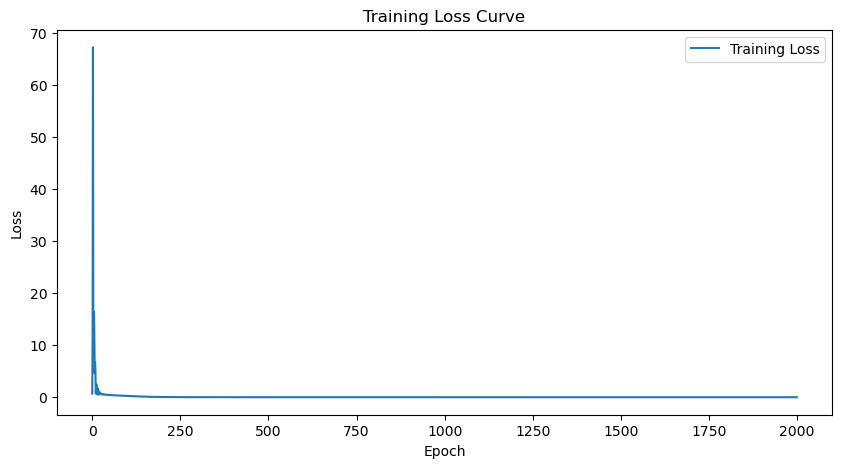

Final Model Accuracy: 67.37%
Final Model F1-score: 0.8050


In [21]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [22]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_reference_last_token.pth'.


In [23]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       0.00      0.00      0.00        31
non_infringement       0.67      1.00      0.81        64

        accuracy                           0.67        95
       macro avg       0.34      0.50      0.40        95
    weighted avg       0.45      0.67      0.54        95



/tmp/ipykernel_663193/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f